In [1]:
import pickle
from util.params import Params
from util.env import set_param
from main import Main
import torch
from models.GDN import GDN
from test_loop import test
from train_loop import train
import pandas as pd
from util.data import getAttacks
from evaluate import createMetrics
import pickle
import matplotlib.pyplot as plt
import os

In [2]:
def plot_with_full_row(df:pd.DataFrame,attacks,run):
    num_plots = len(attacks)  # Number of data points
    num_rows = (num_plots + 1) // 2  # Two columns per row

    # Create a figure with a grid layout, including space for the full-row plot
    fig = plt.figure(figsize=(12, 6 + 5 * num_rows))  # Adjust overall size
    grid = fig.add_gridspec(num_rows + 1, 2)  # Add one row for the overarching plot

    # Full-row plot at the top
    ax_full_row = fig.add_subplot(grid[0, :])  # Span across all columns
    df.plot(ax=ax_full_row)
    ax_full_row.set_title(f"all attacks at run: {run}")
    ax_full_row.legend()

    # Individual subplots below
    for i, attack in enumerate(attacks):
        left=(attack[0]//100)*100
        right=((attack[1]//100)+1)*100
        row, col = divmod(i, 2)  # Determine row and column for the subplot
        ax = fig.add_subplot(grid[row + 1, col])  # Offset by one for the full-row plot
        df.loc[left:right].plot(ax=ax)  # Example plot
        ax.set_title(f"attack {i+1}")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [12]:
main_path="./snapshot/diffpool_batadal/25_04_03_05_16_44"
count=2
thr=1.1

# DATASET 

*Datasets.batadal*


c:\Users\moji\miniconda3\envs\cuda_12_4\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Model is trained. Loading from file .....


numebr of attacks =  219
First attack index is :  1721
Last attack index is :  3803
Number of attacks:  5
Minimum attack len:  6
Maximum attack len:  72
Mean attack len:  42.8


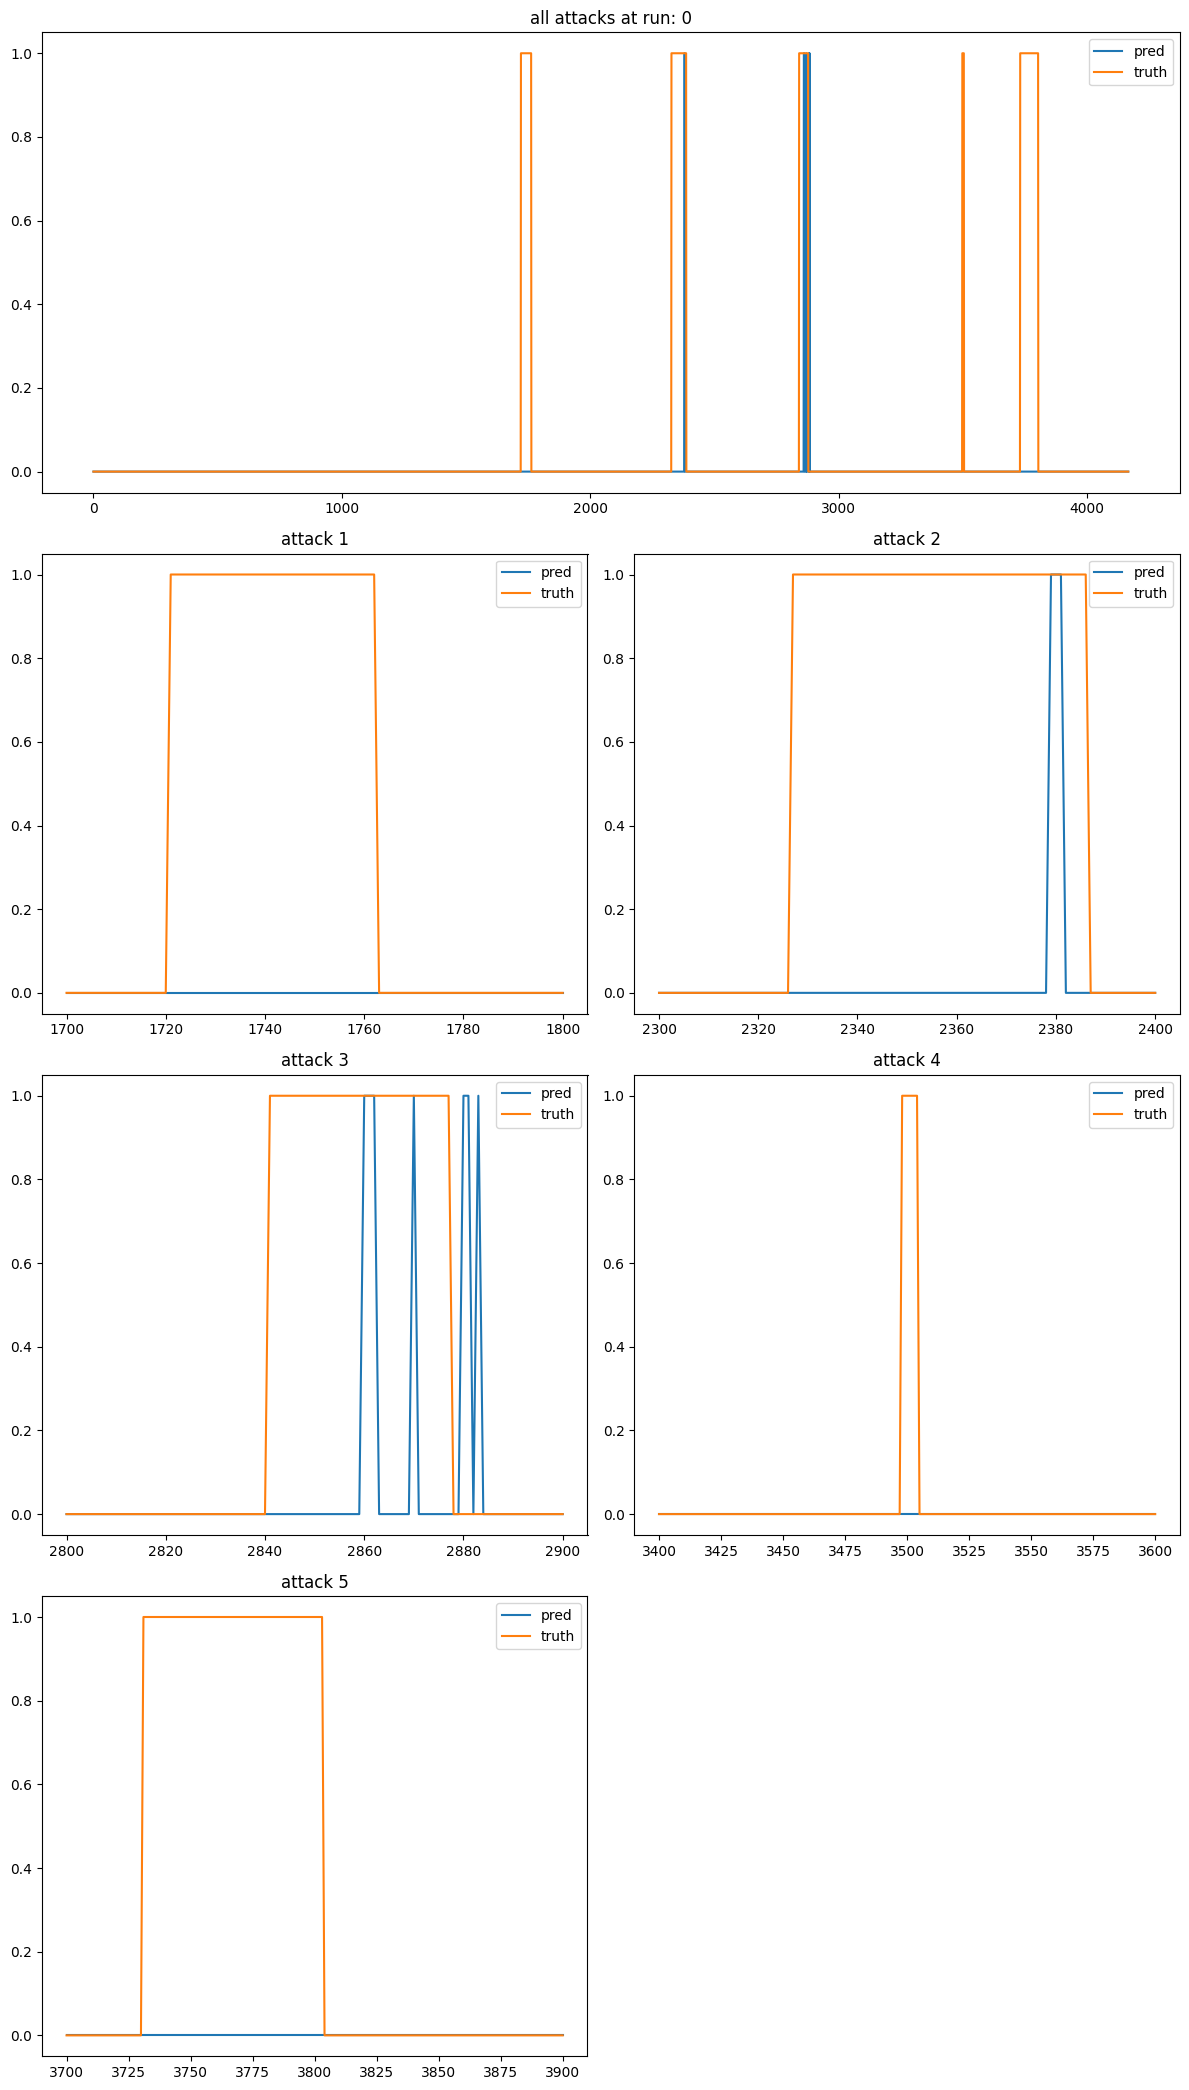

# DATASET 

*Datasets.batadal*


c:\Users\moji\miniconda3\envs\cuda_12_4\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Model is trained. Loading from file .....


numebr of attacks =  219
First attack index is :  1721
Last attack index is :  3803
Number of attacks:  5
Minimum attack len:  6
Maximum attack len:  72
Mean attack len:  42.8


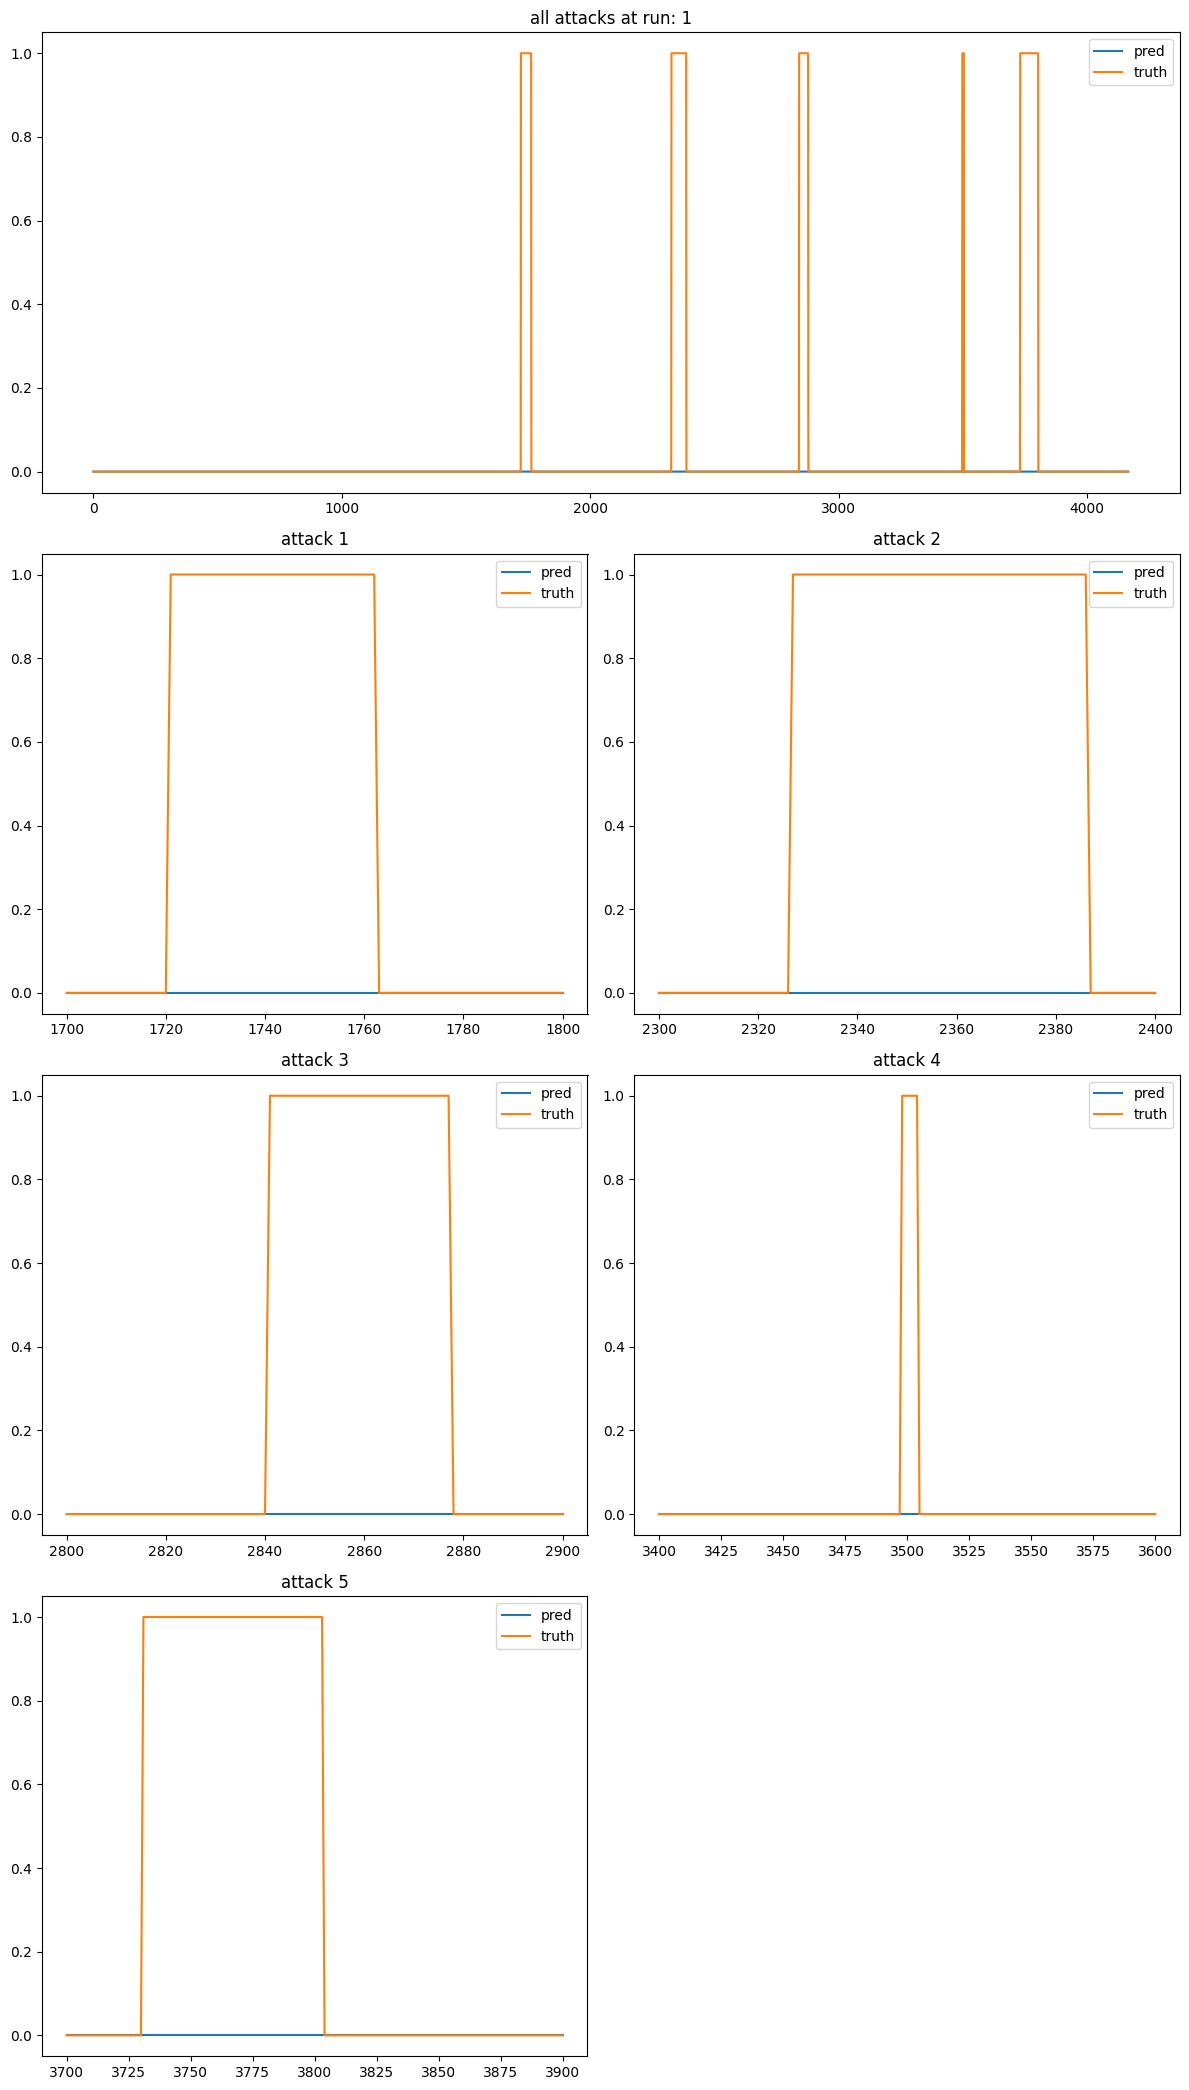

In [13]:
for run in range(count):
  path = f"{main_path}/{run}/"
  if not os.path.exists(f"{path}param.pickle"):
    print(f"Skipping run {run}")
    continue
  param: Params = pickle.load(file=open(f"{path}param.pickle", "rb"))
  mode_dict=pickle.load(file=open(f"{path}model_parameters.pickle", "rb"))
  param.val_ratio=0
  set_param(param)
  # print(param.summary())
  main = Main(param=param,modelParams=mode_dict)

  # print(len(main.train_dataloader),len(main.val_dataloader),len(main.test_dataloader))
  train_avg_loss, train_result = test(main.model, main.train_dataloader)
  # print("train_avg_loss: ",train_avg_loss)
  # val_avg_loss, val_result = test(main.model, main.val_dataloader)
  # val_avg_loss
  test_avg_loss, test_result = test(
              main.model, main.test_dataloader
          )
  # print("test_avg_loss: ",test_avg_loss)
  # print("max: ",test_result[0].max(),
  #     #   val_result[0].max(),
  #       train_result[0].max())
  # print("min: ",test_result[0].min(),
  #     #   val_result[0].min(),
  #       train_result[0].min())

  minimum=0#val_result[0].min()
  maximum=train_result[0].max().item()*thr#*24.5

  pred=torch.where((test_result[0]>maximum) ,torch.tensor(1),torch.tensor(0)).cpu().numpy()
  labels_df=pd.DataFrame({"pred":pred,"truth":test_result[2].cpu().numpy()})
  attacks=getAttacks(labels_df,"truth")
  plot_with_full_row(labels_df,attacks,run)

In [5]:
k=createMetrics(test_result,maximum)
print(k)
k.keys()

{'TP': 0, 'FP': 2, 'TN': 3946, 'FN': 219, 'Accuracy': 0.8996807932853699, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0}


dict_keys(['TP', 'FP', 'TN', 'FN', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [6]:
k2=['TP', 'FP', 'TN', 'FN']
k1=["Accuracy","Precision","Recall","F1"]
d1={key:[] for key in k1}
d2={key:[] for key in k2}
x=[]
for i in range(100):
    _max=maximum*(.5+i/100)
    rr=createMetrics(test_result,_max)
    x.append(_max)
    for key  in d1.keys():
        d1[key].append(float(rr[key]))
    for key  in d2.keys():
        d2[key].append(float(rr[key]))

<Axes: >

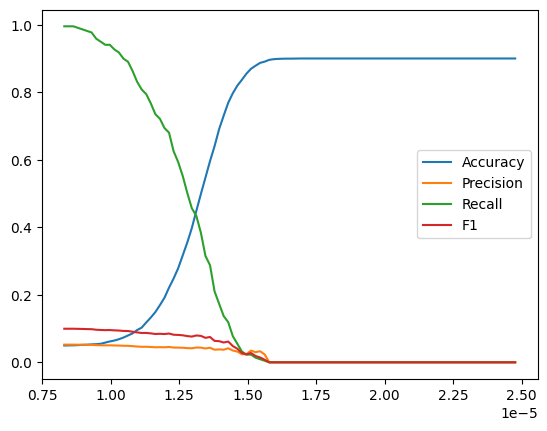

In [7]:
df1=pd.DataFrame(d1,index=x)
df1.plot()

<Axes: >

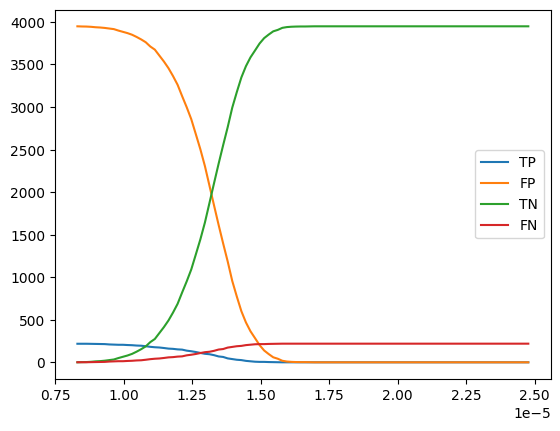

In [8]:
df2=pd.DataFrame(d2,index=x)
df2.plot()